## 1D CNN Using GloVe Word Embedding for 20 News Sentiment Analysis

####  Implemented a 1D Convolutional Neural Network using the GloVe pretrained word embeddings on the 20 Newsgroup dataset.  
 

### import Keras Layers etc.

In [1]:
from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from keras.layers import Dropout
from keras.regularizers import l2
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


### Load Glove6B and Datasets, Data Preprocessing

In [2]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, '/Users/YFXU/downloads/DataSets/glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '/Users/YFXU/downloads/DataSets/20_newsgroup')
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [3]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf-8',errors='ignore') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [4]:
# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    i = t.find('\n\n')  # skip header
                    if 0 < i:
                        t = t[i:]
                    texts.append(t)
                labels.append(label_id)

print('Found %s texts.' % len(texts))

Processing text dataset
Found 19997 texts.


In [5]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 174074 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)


In [6]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Preparing embedding matrix.')

Preparing embedding matrix.


### Preparing Embedding Matrix

In [7]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [8]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

Training model.


### One CNN Layer Model

Trainning results show that the 20 categories news are concentrated on negative sentiment. Train accuracy is 92.0 %, validation accuracy is 78.1%. There existing overfitting.

In [9]:
# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(516, 5, activation='relu')(embedded_sequences)
x = GlobalMaxPooling1D()(x)
x = Dense(516, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         2000100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 516)          258516    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 516)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 516)               266772    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                10340     
Total params: 2,535,728
Trainable params: 535,628
Non-trainable params: 2,000,100
____________________________________________________________

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
epochs=4
batch_size=64
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

Train on 15998 samples, validate on 3999 samples
Epoch 1/4
15998/15998 [==============================] - 761s 48ms/step - loss: 1.5532 - acc: 0.5245 - val_loss: 0.9413 - val_acc: 0.6942
Epoch 2/4
15998/15998 [==============================] - 707s 44ms/step - loss: 0.6654 - acc: 0.7855 - val_loss: 0.7786 - val_acc: 0.7539
Epoch 3/4
15998/15998 [==============================] - 707s 44ms/step - loss: 0.4037 - acc: 0.8724 - val_loss: 0.7180 - val_acc: 0.7732
Epoch 4/4
15998/15998 [==============================] - 706s 44ms/step - loss: 0.2676 - acc: 0.9204 - val_loss: 0.7044 - val_acc: 0.7812


In [12]:
loss, acc = model.evaluate(x_val, y_val, verbose=0)

print('Test Accuracy: %f' % (acc * 100))

Test Accuracy: 78.119530


In [13]:
y_hat = model.predict(x_val)

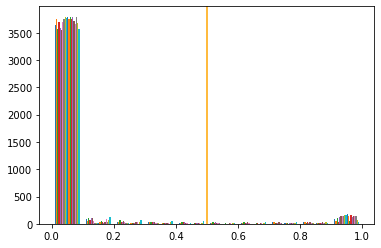

In [14]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [15]:
"{:0.2f}".format(roc_auc_score(y_val, y_hat)*100.0)

'98.52'

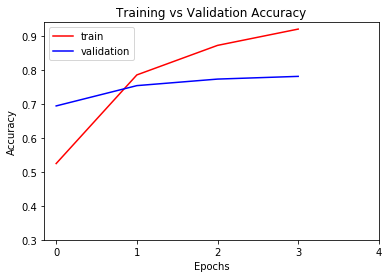

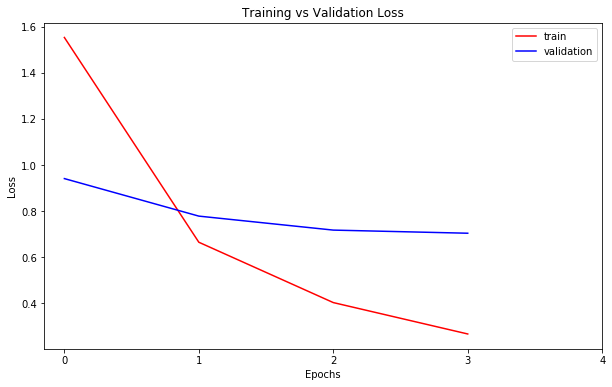

In [16]:
plt.plot(history.history['acc'], color='red')
plt.plot(history.history['val_acc'], color='blue')
plt.xticks(np.arange(0, epochs + 1))
plt.yticks(np.arange(0.3, 1, 0.1))
plt.rcParams['figure.figsize'] = (10, 6)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(['train','validation'])
plt.show()

plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.xticks(np.arange(0, epochs + 1))
plt.rcParams['figure.figsize'] = (5, 3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

### One CNN Layer Model with Binary CrossEntropy Loss

Surprisingly, if the Model using Sigmoid output and binary_crossentropy, the training accuracy is very high: train accuracy is 98.43%, validation accuracy is 97.99. Almost no overfitting. This results can be understood that for each news, the sentiment is concentrated on negative side with a very small part of positive words, that is similar to IMDB binary problem. 

In [17]:
# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(516, 5, activation='relu')(embedded_sequences)
x = GlobalMaxPooling1D()(x)
x = Dense(516, activation='relu')(x)
preds = Dense(len(labels_index), activation='sigmoid')(x)

model = Model(sequence_input, preds)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         2000100   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 996, 516)          258516    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 516)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 516)               266772    
_________________________________________________________________
dense_4 (Dense)              (None, 20)                10340     
Total params: 2,535,728
Trainable params: 535,628
Non-trainable params: 2,000,100
____________________________________________________________

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
epochs=3
batch_size=64
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

Train on 15998 samples, validate on 3999 samples
Epoch 1/3
15998/15998 [==============================] - 709s 44ms/step - loss: 0.1354 - acc: 0.9573 - val_loss: 0.0860 - val_acc: 0.9697
Epoch 2/3
15998/15998 [==============================] - 695s 43ms/step - loss: 0.0659 - acc: 0.9764 - val_loss: 0.0642 - val_acc: 0.9771
Epoch 3/3
15998/15998 [==============================] - 699s 44ms/step - loss: 0.0435 - acc: 0.9843 - val_loss: 0.0570 - val_acc: 0.9799


In [20]:
loss, acc = model.evaluate(x_val, y_val, verbose=0)

print('Test Accuracy: %f' % (acc * 100))

Test Accuracy: 97.985745


In [22]:
y_hat = model.predict(x_val)

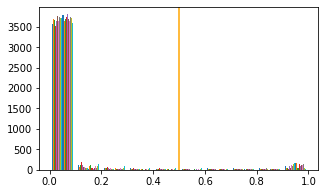

In [23]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [24]:
"{:0.2f}".format(roc_auc_score(y_val, y_hat)*100.0)

'98.29'

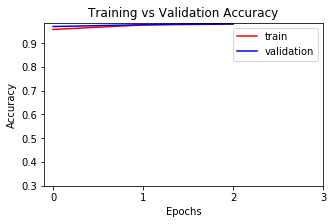

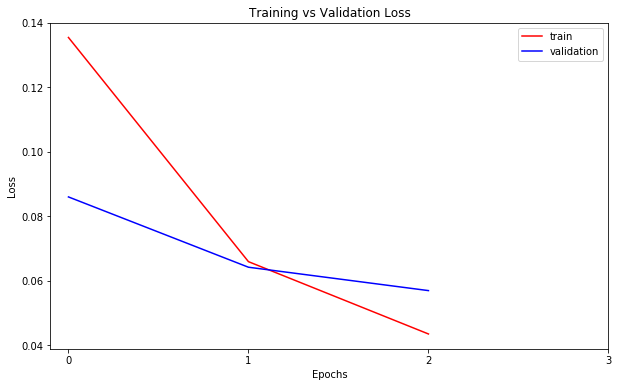

In [25]:
plt.plot(history.history['acc'], color='red')
plt.plot(history.history['val_acc'], color='blue')
plt.xticks(np.arange(0, epochs + 1))
plt.yticks(np.arange(0.3, 1, 0.1))
plt.rcParams['figure.figsize'] = (10, 6)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(['train','validation'])
plt.show()

plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.xticks(np.arange(0, epochs + 1))
plt.rcParams['figure.figsize'] = (5, 3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

### One CNN Layer Model + Regularization

Add the Regularization l2 on the first Dense layer, the overfitting reduced about 40%. However, training accuracy also reduced: train accuracy reduced about 5%, validation accuracy reduced 1%.

In [26]:
# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(516, 5, activation='relu')(embedded_sequences)
x = GlobalMaxPooling1D()(x)
x = Dense(516, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         2000100   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 516)          258516    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 516)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 516)               266772    
_________________________________________________________________
dense_6 (Dense)              (None, 20)                10340     
Total params: 2,535,728
Trainable params: 535,628
Non-trainable params: 2,000,100
____________________________________________________________

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
epochs=4
batch_size=64
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

Train on 15998 samples, validate on 3999 samples
Epoch 1/4
15998/15998 [==============================] - 719s 45ms/step - loss: 3.0161 - acc: 0.5068 - val_loss: 1.4734 - val_acc: 0.6727
Epoch 2/4
15998/15998 [==============================] - 724s 45ms/step - loss: 1.1109 - acc: 0.7553 - val_loss: 1.0423 - val_acc: 0.7494
Epoch 3/4
15998/15998 [==============================] - 716s 45ms/step - loss: 0.7922 - acc: 0.8231 - val_loss: 0.9611 - val_acc: 0.7587
Epoch 4/4
15998/15998 [==============================] - 700s 44ms/step - loss: 0.6487 - acc: 0.8663 - val_loss: 0.9192 - val_acc: 0.7709


In [29]:
loss, acc = model.evaluate(x_val, y_val, verbose=0)

print('Test Accuracy: %f' % (acc * 100))

Test Accuracy: 77.094274


In [30]:
y_hat = model.predict(x_val)

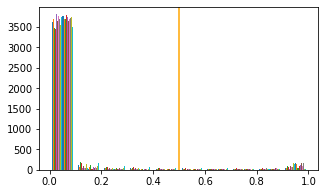

In [31]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [32]:
"{:0.2f}".format(roc_auc_score(y_val, y_hat)*100.0)

'98.48'

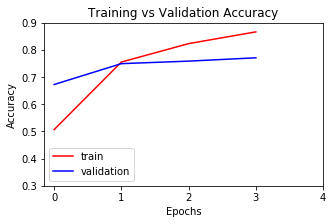

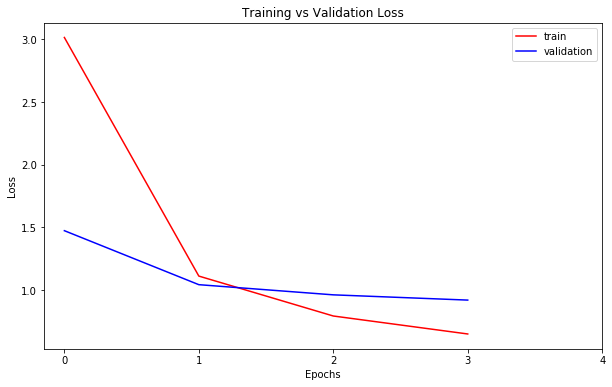

In [33]:
plt.plot(history.history['acc'], color='red')
plt.plot(history.history['val_acc'], color='blue')
plt.xticks(np.arange(0, epochs + 1))
plt.yticks(np.arange(0.3, 1, 0.1))
plt.rcParams['figure.figsize'] = (10, 6)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(['train','validation'])
plt.show()

plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.xticks(np.arange(0, epochs + 1))
plt.rcParams['figure.figsize'] = (5, 3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(['train','validation'])
plt.show()